In [1]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

# If we plot some impact maps now, do they look plausible?

In [3]:
eventsXr=xarray.open_dataset('results/obsEvents.nc')

In [4]:
impactXr=xarray.open_dataset('results/observPrTmaxAnoms.nc')

In [5]:
eventsLs = {
    'summer':['eIndex', 'nino3', 'cIndex','nino4', 'dmi','samSummer'],
    'winter':['eIndex', 'nino3', 'cIndex', 'nino4','dmi','samWinter']
}

# Trends

In [6]:
#change rainfall into % 
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prAnomWinter/(impactXr['prWinter']+impactXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prAnomSummer/(impactXr['prWinter']+impactXr['prSummer'])*100)

tsXr=(impactXr[['tsAnomWinter','tsAnomSummer']])
tsXr=tsXr.rename({'tsAnomWinter':'Winter Temp','tsAnomSummer':'Summer Temp'})

In [7]:
# A function to trim to the area of interest for this study
def domain(ds):
    return ds.where(
    (ds.lat<-28)
        *(ds.lat>-39)
        *(ds.lon>144)
        *(ds.lon<155),
    drop=True
)
    
    

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [8]:
%run utils/emergence.ipynb

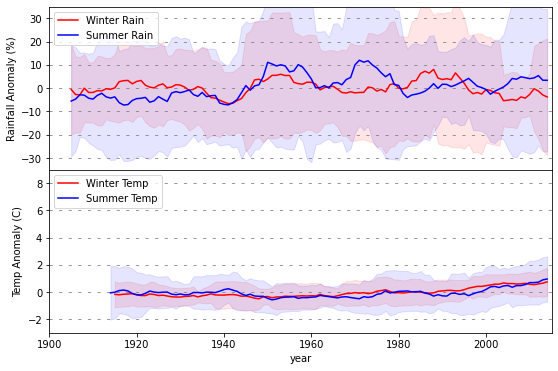

In [9]:
Z=1.96
mainColor=['red','blue','green','orange','purple']
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
dataVars=['Winter Rain','Summer Rain']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2015])
plt.ylim([-35,35])
plt.xticks([])
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplot(2,1,2)
dataVars=['Winter Temp','Summer Temp']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.xlim([1900,2015])
plt.ylim([-3,9])
plt.ylabel('Temp Anomaly (C)')
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplots_adjust(hspace=0)




# Anoms for indiv indices

In [10]:
%run helpers/impactPlots.ipynb

In [11]:
detrendTsXr=tsXr-tsXr.rolling(year=11,center=True).mean('year')

Fire:pos
winter


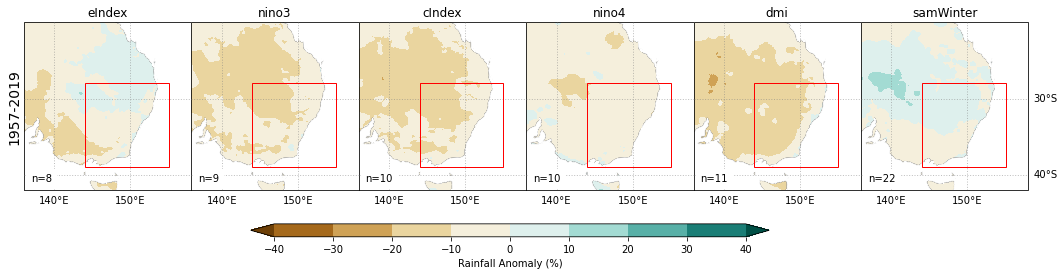

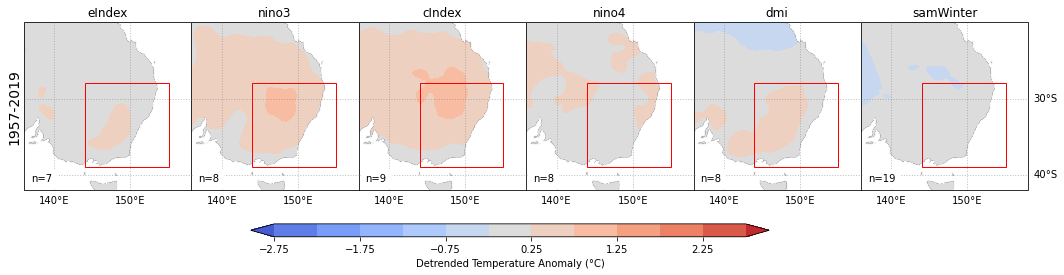

summer


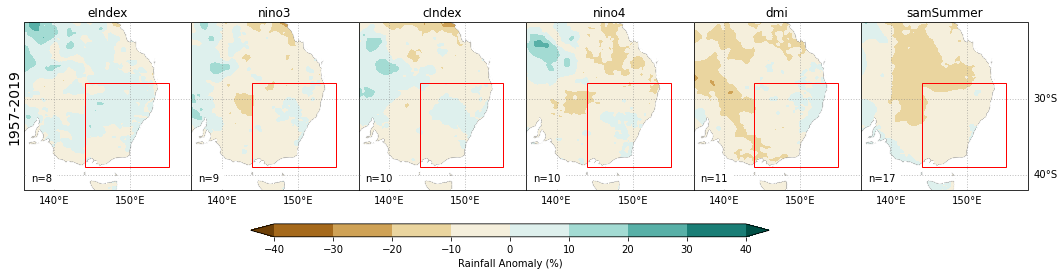

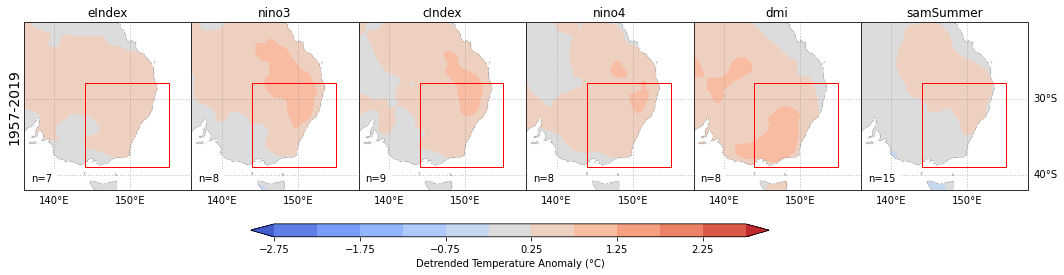

Fire:neg
winter


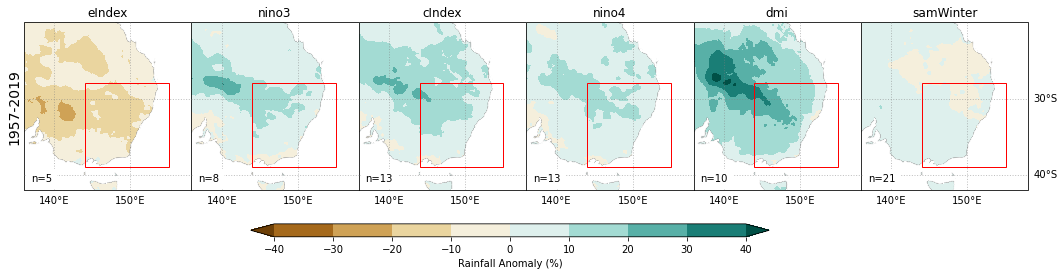

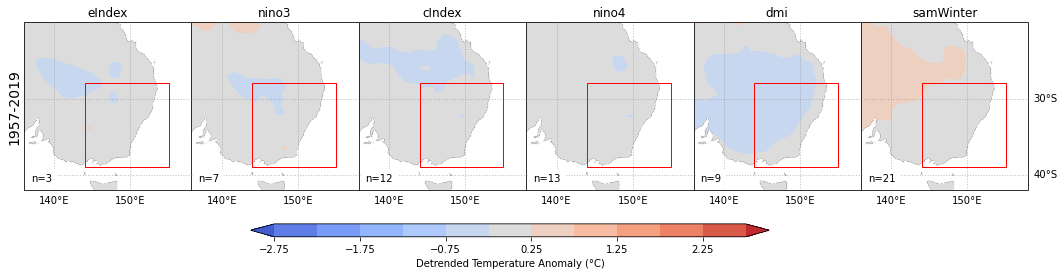

summer


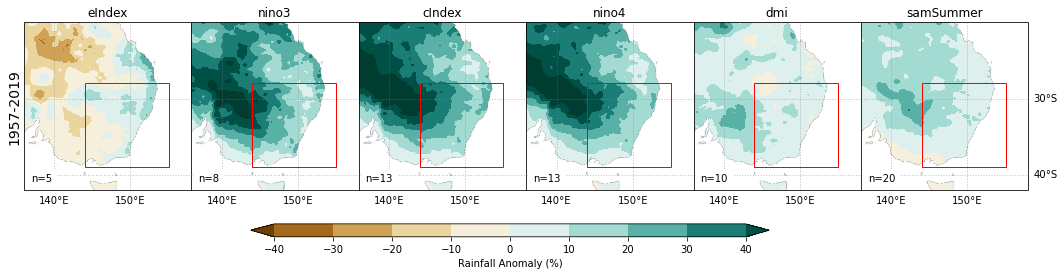

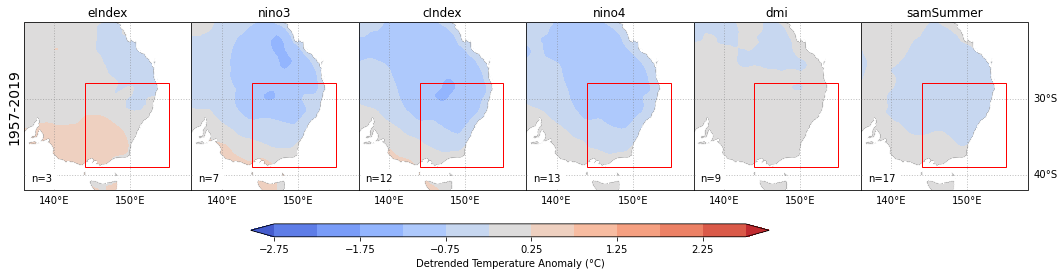

In [12]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason], #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

# Compound them and see what happens

In [13]:
allCompounds=compound.compound(eventsXr)

eIndexEastioSamsummer
eIndexEastioSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
nino4EastioSamsummer
nino4EastioSamwinter
nino4DmiSamsummer
nino4DmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
nino34DmiSamsummer
nino34DmiSamwinter
nino3EastioSamsummer
nino3EastioSamwinter
nino3DmiSamsummer
nino3DmiSamwinter


In [14]:
indexSet='ecCombinedDmiSam'

In [16]:
eventsList=['enso+iod', 'enso+sam', 'iod+sam', 'all3']

Fire:pos
winter


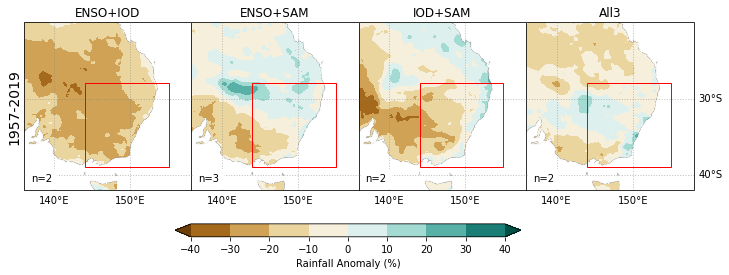

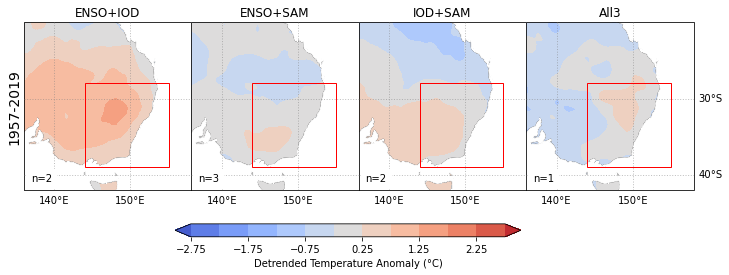

summer


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


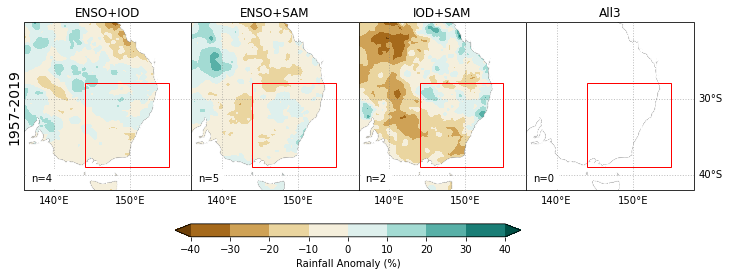

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


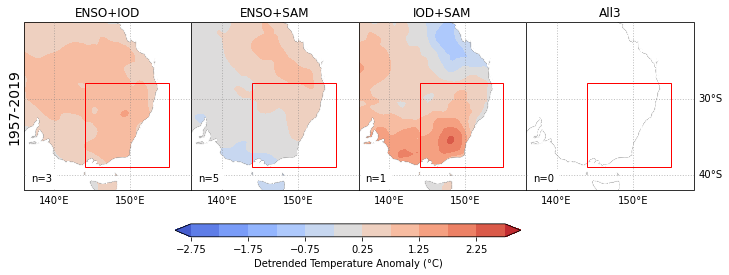

Fire:neg
winter


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


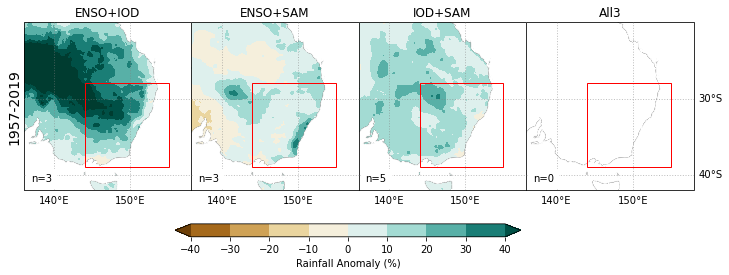

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


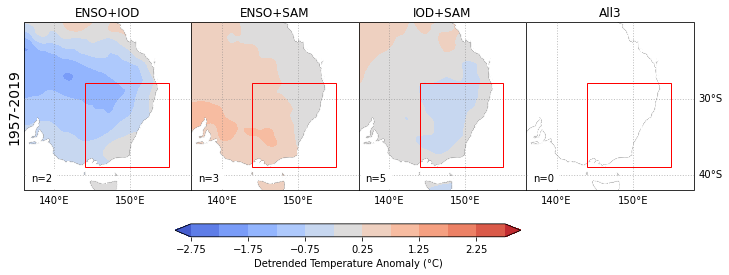

summer


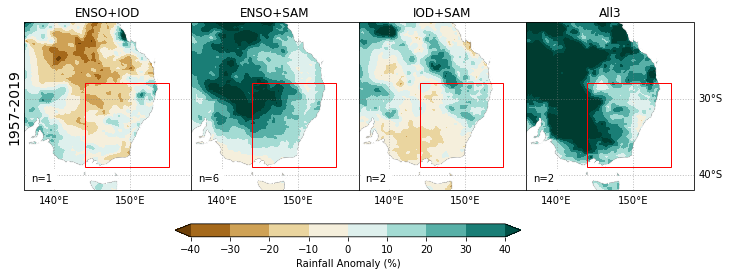

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


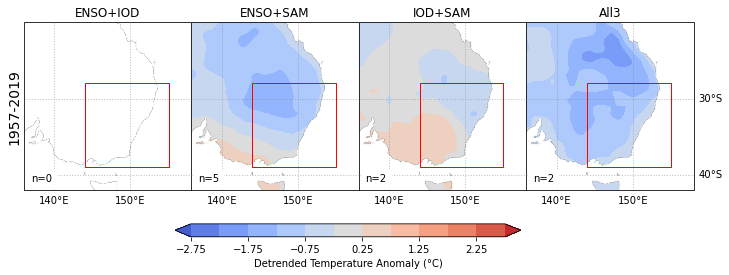

In [17]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            eventsList,
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

Fire:pos
winter


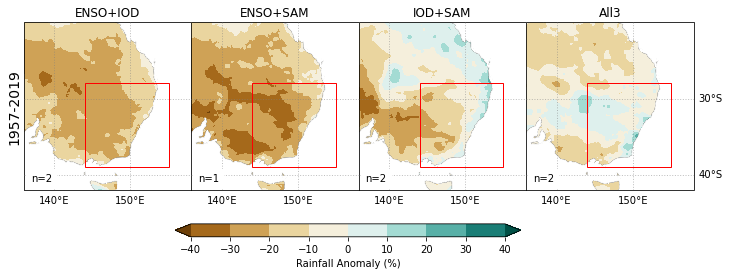

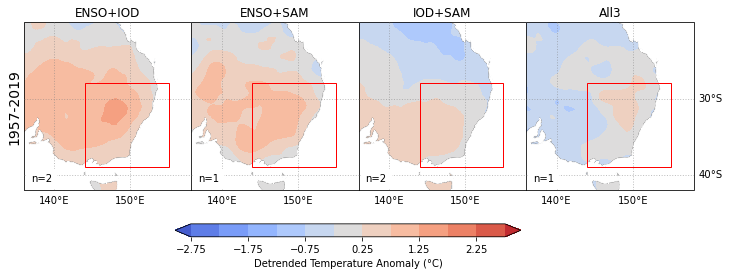

summer


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


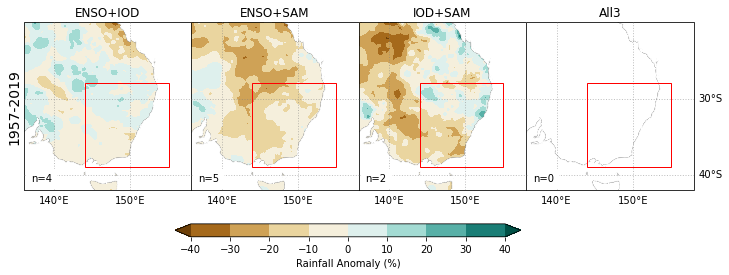

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


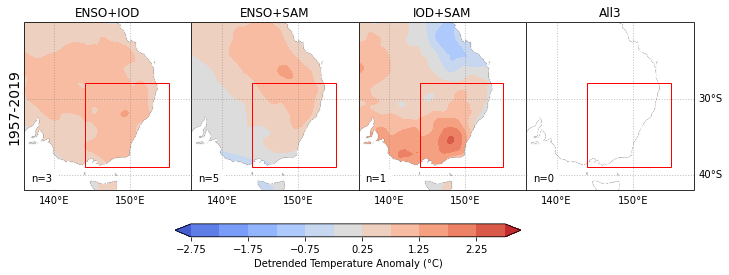

Fire:neg
winter


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


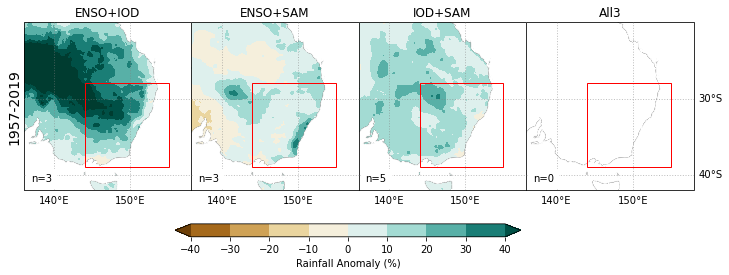

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


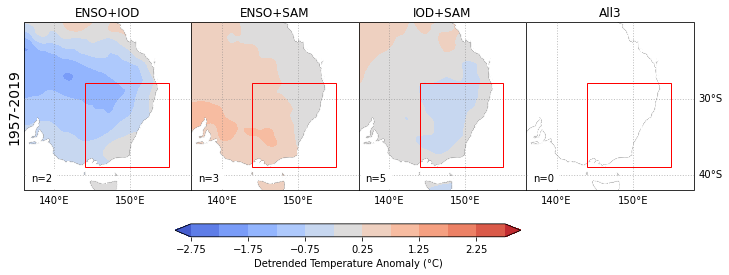

summer


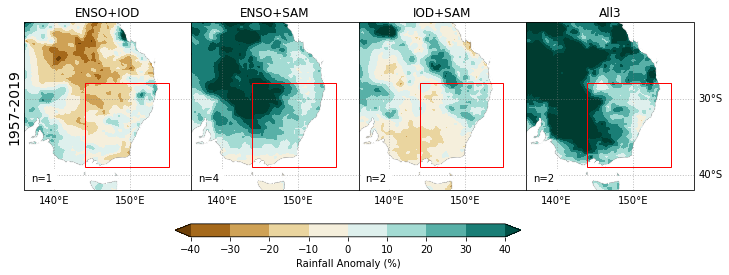

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


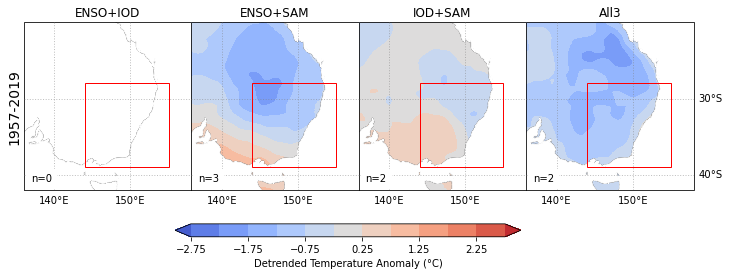

In [19]:
%run helpers/impactPlots.ipynb
indexSet='nino34DmiSam'
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompounds[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), 
            eventsList,
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

# And comparison between the three enso indices

In [20]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

NameError: name 'compoundEventsXr' is not defined

In [ ]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [ ]:
ensoIodEventsLs

In [ ]:
ensoIodEventLs=[
    'ecCombinedDmiSam',
    'cIndexDmiSam',
    'eIndexDmiSam',
    'nino34DmiSam'
]


In [ ]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()